<a href="https://colab.research.google.com/github/jenifer8092/Evaluaci-n-de-Modelos-de-Machine-Learning-y-Redes-Neuronales/blob/main/Parcial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🧑‍💻Examen: Evaluación de Modelos de Machine Learning y Redes Neuronales (Versión Estudiante)
## Autores: Jenifer Roa y Tobías Romero.

---



## Importanción de Librerías

In [93]:
import pandas as pd
import numpy as np
from datetime import datetime
import re
import joblib
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Configuración de plots
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

## Carga de datos

In [94]:
# Definimos la ruta del archivo CSV
dataset = "dataset.csv"
df = pd.read_csv(dataset)

## Parte 1: Exploración y Limpieza de Datos

### 1.1 Exploración Inicial: Tamaños, tipos y valores únicos.

In [95]:
print(f"Forma del dataset: {df.shape}")
print(f"Tipos de datos: {df.dtypes}")
print(f"Información detallada: {df.info}")
# Valores únicos
for col in df.columns:
    unique_count = df[col].nunique()
    print(f"{col}: {unique_count} valores únicos")
    if unique_count < 20:
        print(f"  Valores: {sorted(df[col].dropna().unique())}")
    print()

print(f"Valores nulos: {df.isnull().sum()}")
#Estadísticas descriptivas
print(df.describe(include='all'))
display(df.head())

Forma del dataset: (500000, 11)
Tipos de datos: ID                    int64
Edad                float64
Genero               object
Ingresos_Anuales    float64
HistorialCredito    float64
Casado               object
Default              object
FechaNacimiento      object
Telefono             object
Pais                 object
CodigoPostal         object
dtype: object
Información detallada: <bound method DataFrame.info of             ID   Edad     Genero  Ingresos_Anuales  HistorialCredito Casado  \
0            1   44.0          f           73500.0              91.0    NaN   
1            2   19.0     Female           37000.0              51.0     No   
2            3   80.0   femenino           17000.0              83.0     SI   
3            4   85.0     Female           76500.0              35.0      Y   
4            5   86.0          F           96500.0              26.0     No   
...        ...    ...        ...               ...               ...    ...   
499995  499996   47.0 

,ID,Edad,Genero,Ingresos_Anuales,HistorialCredito,Casado,Default,FechaNacimiento,Telefono,Pais,CodigoPostal
0,1,44.0,f,73500.0,91.0,NaN,0,1993-03-19,12345,Chile,8340000
1,2,19.0,Female,37000.0,51.0,No,No,1977-12-18,3237353327,Perú,04001
2,3,80.0,femenino,17000.0,83.0,SI,Si,1963-04-21,12345,Argentina,X5000
3,4,85.0,Female,76500.0,35.0,Y,0,2003-04-02,3930297402,Perú,17001
4,5,86.0,F,96500.0,26.0,No,no,1960-10-28,12345,Perú,17001


### 1.2 Tratamiento de outliers.

In [96]:
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers.index

In [97]:
def treat_outliers(df):
    df_clean = df.copy()
    numeric_columns = ['Edad', 'Ingresos_Anuales', 'HistorialCredito']

    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            outlier_indices = detect_outliers_iqr(df_clean, col)

            if len(outlier_indices) > 0:
                print(f"Outliers detectados en {col}: {len(outlier_indices)}")
                Q1 = df_clean[col].quantile(0.25)
                Q3 = df_clean[col].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR

                df_clean.loc[df_clean[col] < lower_bound, col] = lower_bound
                df_clean.loc[df_clean[col] > upper_bound, col] = upper_bound

    return df_clean

In [98]:
df = treat_outliers(df)

Outliers detectados en Edad: 6691
Outliers detectados en Ingresos_Anuales: 2796


### 1.3 Remover duplicados.

In [99]:
duplicados_antes = df.duplicated().sum()
print(f"Filas duplicadas encontradas: {duplicados_antes}")

Filas duplicadas encontradas: 0


In [100]:
df = df.drop_duplicates()
print(f"Dataset después de remover duplicados: {df.shape}")

Dataset después de remover duplicados: (500000, 11)


### 1.4 Normalización de columna *FechaNacimiento*

In [101]:
from datetime import datetime

def normalize_birth_date(df):
    df_clean = df.copy()

    def parse_date(date_str):
        if pd.isna(date_str):
            return pd.NaT

        date_str = str(date_str).strip()

        # Casos específicos problemáticos
        if '1990-13-40' in date_str or 'invalid' in date_str.lower():
            return pd.NaT

        date_formats = ['%Y-%m-%d', '%d/%m/%Y', '%m/%d/%Y', '%Y/%m/%d', '%d-%m-%Y', '%d.%m.%Y', '%Y.%m.%d']

        for fmt in date_formats:
            try:
                parsed_date = pd.to_datetime(date_str, format=fmt)
                if 1900 <= parsed_date.year <= datetime.now().year:
                    return parsed_date
            except:
                continue

        try:
            parsed_date = pd.to_datetime(date_str, errors='coerce')
            if pd.notna(parsed_date) and 1900 <= parsed_date.year <= datetime.now().year:
                return parsed_date
        except:
            pass

        return pd.NaT

    if 'FechaNacimiento' in df_clean.columns:
        df_clean['FechaNacimiento'] = df_clean['FechaNacimiento'].apply(parse_date)

        # Calcular fecha promedio para imputación posterior
        valid_dates = df_clean['FechaNacimiento'].dropna()
        if len(valid_dates) > 0:
            average_birth_date = valid_dates.median()
            print(f"Fechas de nacimiento normalizadas. Fecha promedio calculada: {average_birth_date.date()}")
            # Guardar temporalmente para uso en handle_missing_values
            df_clean['_temp_avg_birth_date'] = average_birth_date
        else:
            print("No hay fechas válidas para calcular promedio")
            df_clean['_temp_avg_birth_date'] = pd.NaT

    return df_clean

df = normalize_birth_date(df)

Fechas de nacimiento normalizadas. Fecha promedio calculada: 1980-07-09


### 1.5 Normalización de columna *Telefono*

In [102]:
def clean_phone(df):
    df_clean = df.copy()

    if 'Telefono' in df_clean.columns:
        def clean_phone_number(phone):
            if pd.isna(phone):
                return np.nan

            # Convertir a string y quitar espacios
            phone_str = str(phone).strip()

            # Si comienza con (57), quitarlo
            if phone_str.startswith('(57)'):
                phone_str = phone_str[4:].strip()

            # Conservar solo los caracteres que sean dígitos
            cleaned_digits = ''.join(ch for ch in phone_str if ch.isdigit())

            # Si después de limpiar no queda nada o es puro cero, devolver NaN
            if not cleaned_digits or set(cleaned_digits) == {'0'}:
                return np.nan

            return cleaned_digits

        df_clean['Telefono'] = df_clean['Telefono'].apply(clean_phone_number)
        print("Columna de teléfono limpiada")

    return df_clean

df = clean_phone(df)

Columna de teléfono limpiada


### 1.6 Estandarización de columnas categóricas.

In [103]:
def standardize_categorical(df):
    df_clean = df.copy()

    # Estandarizar columna Casado
    if 'Casado' in df_clean.columns:
        casado_map = {
            'si': 'Si', 'SI': 'Si', 'yes': 'Si', 'YES': 'Si', 'y': 'Si', 'Y': 'Si', 'Yes': 'Si',
            'no': 'No', 'NO': 'No', 'n': 'No', 'N': 'No'
        }
        df_clean['Casado'] = df_clean['Casado'].astype(str).map(casado_map).fillna(df_clean['Casado'])

    # Estandarizar columna Genero
    if 'Genero' in df_clean.columns:
        genero_map = {
            'f': 'F', 'female': 'F', 'Female': 'F', 'femenino': 'F',
            'm': 'M', 'male': 'M', 'Male': 'M', 'masculino': 'M'
        }
        df_clean['Genero'] = df_clean['Genero'].astype(str).map(genero_map).fillna(df_clean['Genero'])

    # Estandarizar columna Default
    if 'Default' in df_clean.columns:
        default_map = {
            'si': 'Si', 'SI': 'Si', 'yes': 'Si', 'YES': 'Si', '1': 'Si',
            'no': 'No', 'NO': 'No', '0': 'No'
        }
        df_clean['Default'] = df_clean['Default'].astype(str).map(default_map).fillna(df_clean['Default'])

    print("Columnas categóricas estandarizadas")
    return df_clean

df = standardize_categorical(df)

Columnas categóricas estandarizadas


### 1.7 Validación de consistencia de *Código Postal* y *País*

In [104]:
class PostalCodeFixer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.postal_modes_ = {}

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()

        if 'CodigoPostal' in X_df.columns and 'Pais' in X_df.columns:
            for pais in X_df['Pais'].unique():
                if pd.notna(pais):
                    mask_pais = X_df['Pais'] == pais
                    codigos_pais = X_df[mask_pais]['CodigoPostal'].dropna()

                    if len(codigos_pais) > 0:
                        moda_codigo = codigos_pais.mode().iloc[0] if len(codigos_pais.mode()) > 0 else codigos_pais.iloc[0]
                        self.postal_modes_[pais] = moda_codigo

        return self

    def transform(self, X):
        X_df = pd.DataFrame(X) if not isinstance(X, pd.DataFrame) else X.copy()

        if 'CodigoPostal' in X_df.columns and 'Pais' in X_df.columns:
            for pais, moda_codigo in self.postal_modes_.items():
                mask_pais = X_df['Pais'] == pais
                X_df.loc[mask_pais & X_df['CodigoPostal'].isna(), 'CodigoPostal'] = moda_codigo

        return X_df

### 1.8 Manejo de datos nulos.

In [105]:
def calculate_age_from_birth(birth_date):
    if pd.isna(birth_date):
        return np.nan
    try:
        today = datetime.now()
        age = today.year - birth_date.year - ((today.month, today.day) < (birth_date.month, birth_date.day))
        return age if 0 <= age <= 120 else np.nan
    except:
        return np.nan

In [106]:
def handle_missing_values(df):
    df_clean = df.copy()

    if 'FechaNacimiento' in df_clean.columns and 'Edad' in df_clean.columns:
        df_clean['Edad'] = pd.to_numeric(df_clean['Edad'], errors='coerce')

        # Identificar edades problemáticas (negativas, decimales, >00)
        mask_edad_problematica = (
            df_clean['Edad'].isna() |
            (df_clean['Edad'] < 0) |
            (df_clean['Edad'] > 100) |
            (df_clean['Edad'] != df_clean['Edad'].round())
        )

        print(f"Edades problemáticas detectadas: {mask_edad_problematica.sum()}")
        if mask_edad_problematica.sum() > 0:
            # Mostrar algunos valores problemáticos
            problematic_values = df_clean.loc[mask_edad_problematica, 'Edad'].dropna().tolist()
            print(f"edades problemáticas: {problematic_values[:5]}")

        # ESTRATEGIA 1: Calcular edad desde fecha de nacimiento válida
        df_clean['Edad_Calculada'] = df_clean['FechaNacimiento'].apply(calculate_age_from_birth)
        mask_fecha_valida = df_clean['Edad_Calculada'].notna()

        # Corregir edades problemáticas con edad calculada
        edades_corregidas = mask_edad_problematica & mask_fecha_valida
        if edades_corregidas.any():
            df_clean.loc[edades_corregidas, 'Edad'] = df_clean.loc[edades_corregidas, 'Edad_Calculada']
            print(f"Edades corregidas desde fecha de nacimiento: {edades_corregidas.sum()}")

        # ESTRATEGIA 2: Para casos sin fecha válida, imputar fecha promedio
        mask_sin_fecha = mask_edad_problematica & (~mask_fecha_valida)

        if mask_sin_fecha.any():
            if '_temp_avg_birth_date' in df_clean.columns:
                fecha_promedio = df_clean['_temp_avg_birth_date'].iloc[0]

                if pd.notna(fecha_promedio):
                    print(f"Imputando fecha promedio para {mask_sin_fecha.sum()} casos sin fecha válida")

                    # Imputar fecha promedio
                    df_clean.loc[mask_sin_fecha, 'FechaNacimiento'] = fecha_promedio

                    # Calcular edad desde fecha promedio
                    edad_desde_promedio = calculate_age_from_birth(fecha_promedio)

                    if pd.notna(edad_desde_promedio):
                        df_clean.loc[mask_sin_fecha, 'Edad'] = edad_desde_promedio
                        print(f"Edad calculada desde fecha promedio: {edad_desde_promedio}")
                    else:
                        print("Error: No se pudo calcular edad desde fecha promedio")
                else:
                    print("No hay fecha promedio válida")
            else:
                print("No se encontró fecha promedio calculada")

        # Verificar si aún quedan edades problemáticas
        mask_aun_problematicas = (
            df_clean['Edad'].isna() |
            (df_clean['Edad'] < 0) |
            (df_clean['Edad'] > 100) |
            (df_clean['Edad'] != df_clean['Edad'].round())
        )

        if mask_aun_problematicas.any():
            print(f"Aún quedan {mask_aun_problematicas.sum()} edades problemáticas")
            problematic_remaining = df_clean.loc[mask_aun_problematicas, 'Edad'].dropna().tolist()
            print(f"Valores problemáticos restantes: {problematic_remaining[:5]}")

        df_clean.drop(['Edad_Calculada'], axis=1, inplace=True, errors='ignore')

    # Limpiar columna temporal
    if '_temp_avg_birth_date' in df_clean.columns:
        df_clean.drop('_temp_avg_birth_date', axis=1, inplace=True)

    # IMPUTACIÓN ESTÁNDAR PARA FECHAS DE NACIMIENTO NULAS
    if 'FechaNacimiento' in df_clean.columns:
        fechas_nulas = df_clean['FechaNacimiento'].isna().sum()
        if fechas_nulas > 0:
            # Usar fecha moda de las fechas válidas
            fechas_validas = df_clean['FechaNacimiento'].dropna()
            if len(fechas_validas) > 0:
                fecha_moda = fechas_validas.mode().iloc[0] if len(fechas_validas.mode()) > 0 else fechas_validas.median()
                df_clean['FechaNacimiento'].fillna(fecha_moda, inplace=True)
                print(f"Fechas de nacimiento nulas imputadas con moda: {fecha_moda.date()} (casos: {fechas_nulas})")

    # IMPUTACIÓN PARA OTRAS COLUMNAS
    numeric_columns = ['Ingresos_Anuales', 'HistorialCredito']  # Edad ya se manejó arriba
    categorical_columns = ['Genero', 'Casado', 'Default', 'Pais', 'CodigoPostal', 'Telefono']

    for col in numeric_columns:
        if col in df_clean.columns:
            df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')
            if df_clean[col].isna().any():
                moda = df_clean[col].mode().iloc[0] if len(df_clean[col].mode()) > 0 else df_clean[col].median()
                casos_imputados = df_clean[col].isna().sum()
                df_clean[col].fillna(moda, inplace=True)
                print(f"Valores nulos en {col} imputados con moda: {moda} (casos: {casos_imputados})")

    for col in categorical_columns:
        if col in df_clean.columns:
            if df_clean[col].isna().any():
                moda = df_clean[col].mode().iloc[0] if len(df_clean[col].mode()) > 0 else 'Desconocido'
                casos_imputados = df_clean[col].isna().sum()
                df_clean[col].fillna(moda, inplace=True)
                print(f"Valores nulos en {col} imputados con moda: {moda} (casos: {casos_imputados})")

    # VERIFICACIÓN FINAL
    edades_finales_problematicas = ((df_clean['Edad'] < 0) | (df_clean['Edad'] > 120)).sum() if 'Edad' in df_clean.columns else 0
    print(f"VERIFICACIÓN FINAL - Edades problemáticas restantes: {edades_finales_problematicas}")

    return df_clean

df = handle_missing_values(df)

Edades problemáticas detectadas: 20007
edades problemáticas: [-5.0, 127.5, -5.0, 127.5, -5.0]
Edades corregidas desde fecha de nacimiento: 20005
Imputando fecha promedio para 2 casos sin fecha válida
Edad calculada desde fecha promedio: 45
Fechas de nacimiento nulas imputadas con moda: 1980-12-25 (casos: 42)
Valores nulos en Ingresos_Anuales imputados con moda: 97000.0 (casos: 2772)
Valores nulos en HistorialCredito imputados con moda: 25.0 (casos: 6166)
Valores nulos en Genero imputados con moda: F (casos: 62308)
Valores nulos en Casado imputados con moda: No (casos: 71279)
Valores nulos en Telefono imputados con moda: 3112190805 (casos: 62398)
VERIFICACIÓN FINAL - Edades problemáticas restantes: 0


In [73]:
display(df.head(20))

,ID,Edad,Genero,Ingresos_Anuales,HistorialCredito,Casado,Default,FechaNacimiento,Telefono,Pais,CodigoPostal
0,1,44.0,F,73500.0,91.0,No,No,1993-03-19,12345,Chile,8340000
1,2,19.0,F,37000.0,51.0,No,No,1977-12-18,3237353327,Perú,04001
2,3,80.0,F,17000.0,83.0,Si,Si,1963-04-21,12345,Argentina,X5000
3,4,85.0,F,76500.0,35.0,Si,No,2003-04-02,3930297402,Perú,17001
4,5,86.0,F,96500.0,26.0,No,No,1960-10-28,12345,Perú,17001
5,6,54.0,M,81500.0,41.0,No,No,1982-03-29,12345,México,01000
6,7,68.0,M,57000.0,70.0,Si,No,1994-03-07,3112190805,Argentina,M5500
7,8,62.0,F,62000.0,23.0,Si,No,1963-09-04,3112190805,Argentina,M5500
8,9,34.0,F,73500.0,87.0,No,Si,1985-02-09,3112190805,Argentina,B1600
9,10,30.0,M,97000.0,63.0,No,No,1961-05-06,3718548711,Perú,04001


## 2. Preparación de datos

In [74]:
# Cargar datos
df = pd.read_csv('dataset.csv')

print("=== INFORMACIÓN INICIAL ===")
print(f"Forma del dataset: {df.shape}")
print(f"Columnas: {list(df.columns)}")

# Verificar si existe columna objetivo
target_column = 'Default'
if target_column not in df.columns:
    print(f"Columna objetivo '{target_column}' no encontrada. Columnas disponibles: {list(df.columns)}")

# Separar features y target
X = df.drop([target_column], axis=1)
y = df[target_column]

# Convertir target a binario
def encode_target(y):
    if y.dtype == 'object':
        y_encoded = y.map({'Si': 1, 'si': 1, 'YES': 1, 'yes': 1, '1': 1, 1: 1,
                          'No': 0, 'no': 0, 'NO': 0, '0': 0, 0: 0})
        return y_encoded.fillna(0).astype(int)
    return y

y_encoded = encode_target(y)

print(f"\nDistribución de la variable objetivo:")
print(y_encoded.value_counts())

=== INFORMACIÓN INICIAL ===
Forma del dataset: (500000, 11)
Columnas: ['ID', 'Edad', 'Genero', 'Ingresos_Anuales', 'HistorialCredito', 'Casado', 'Default', 'FechaNacimiento', 'Telefono', 'Pais', 'CodigoPostal']

Distribución de la variable objetivo:
Default
0    250151
1    249849
Name: count, dtype: int64


### 2.1 Definir columnas categóricas

In [75]:
# Identificar columnas numéricas y categóricas
numeric_features = ['Edad', 'Ingresos_Anuales', 'HistorialCredito']
categorical_features = ['Genero', 'Casado', 'Pais', 'CodigoPostal', 'Telefono']
date_features = ['FechaNacimiento']

# Filtrar solo las columnas que existen en el dataset
numeric_features = [col for col in numeric_features if col in X.columns]
categorical_features = [col for col in categorical_features if col in X.columns]
date_features = [col for col in date_features if col in X.columns]

print(f"\nCaracterísticas numéricas: {numeric_features}")
print(f"Características categóricas: {categorical_features}")
print(f"Características de fecha: {date_features}")


Características numéricas: ['Edad', 'Ingresos_Anuales', 'HistorialCredito']
Características categóricas: ['Genero', 'Casado', 'Pais', 'CodigoPostal', 'Telefono']
Características de fecha: ['FechaNacimiento']




---


## 3. Creación de Pipeline


### 3.1 Pipeline de limpieza usando las funciones personalizadas de limpieza.

In [76]:
def remove_duplicates_func(df):
    return df.drop_duplicates()

cleaning_pipeline = Pipeline([
    ('remove_duplicates', FunctionTransformer(func=remove_duplicates_func, validate=False)),
    ('normalize_dates', FunctionTransformer(normalize_birth_date, validate=False)),
    ('clean_phones', FunctionTransformer(clean_phone, validate=False)),
    ('standardize_categorical', FunctionTransformer(standardize_categorical, validate=False)),
    ('fix_postal_codes', PostalCodeFixer()),  # Esta necesita fit
    ('calculate_age', FunctionTransformer(handle_missing_values, validate=False)),
    ('treat_outliers', FunctionTransformer(treat_outliers, validate=False))
])

### 3.2 Pipeline de preprocesamiento por tipo de dato

In [77]:
numeric_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'))
])

In [78]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_pipeline, numeric_features),
        ('cat', categorical_pipeline, categorical_features)
    ],
    remainder='drop'
)

### 3.3 Pipeline completo.

In [79]:
complete_pipeline = Pipeline([
    ('cleaning', cleaning_pipeline),
    ('preprocessing', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ))
])

## 4. División de datos.

In [80]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

print(f"\n=== DIVISIÓN DE DATOS ===")
print(f"Entrenamiento: {X_train.shape[0]} muestras")
print(f"Prueba: {X_test.shape[0]} muestras")
print(f"Distribución train: {np.bincount(y_train)}")
print(f"Distribución test: {np.bincount(y_test)}")


=== DIVISIÓN DE DATOS ===
Entrenamiento: 400000 muestras
Prueba: 100000 muestras
Distribución train: [200121 199879]
Distribución test: [50030 49970]


## 5. Entrenamiento usando pipeline.

In [81]:
print("\n=== ENTRENANDO MODELO ===")
complete_pipeline.fit(X_train, y_train)


=== ENTRENANDO MODELO ===
Fechas de nacimiento normalizadas. Fecha promedio calculada: 1980-07-09
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 15986
edades problemáticas: [200.0, 200.0, -5.0, -5.0, 200.0]
Edades corregidas desde fecha de nacimiento: 15984
Imputando fecha promedio para 2 casos sin fecha válida
Edad calculada desde fecha promedio: 45
Fechas de nacimiento nulas imputadas con moda: 1980-12-25 (casos: 27)
Valores nulos en Ingresos_Anuales imputados con moda: 97000.0 (casos: 2189)
Valores nulos en HistorialCredito imputados con moda: 100.0 (casos: 4921)
Valores nulos en Genero imputados con moda: F (casos: 49837)
Valores nulos en Casado imputados con moda: No (casos: 57201)
Valores nulos en Telefono imputados con moda: 3112190805 (casos: 49854)
VERIFICACIÓN FINAL - Edades problemáticas restantes: 0
Outliers detectados en Ingresos_Anuales: 2222


Pipeline(steps=[('cleaning',
                 Pipeline(steps=[('remove_duplicates',
                                  FunctionTransformer(func=<function remove_duplicates_func at 0x7c219be61e40>)),
                                 ('normalize_dates',
                                  FunctionTransformer(func=<function normalize_birth_date at 0x7c219be60360>)),
                                 ('clean_phones',
                                  FunctionTransformer(func=<function clean_phone at 0x7c219ea299e0>)),
                                 ('standardize_categorical',
                                  Function...
                                                  ['Edad', 'Ingresos_Anuales',
                                                   'HistorialCredito']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Genero', 'Casado', 'Pais',
                                                   'CodigoPostal',
                                                   'Telefono'])])),
                ('classifier',
                 RandomForestClassifier(max_depth=10, min_samples_leaf=2,
                                        min_samples_split=5,
                                        random_state=42))])

## 6. Predicción y evaluación.

Fechas de nacimiento normalizadas. Fecha promedio calculada: 1980-07-09
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 4021
edades problemáticas: [200.0, 200.0, 200.0, 200.0, 200.0]
Edades corregidas desde fecha de nacimiento: 4021
Fechas de nacimiento nulas imputadas con moda: 1969-10-04 (casos: 15)
Valores nulos en Ingresos_Anuales imputados con moda: 28500.0 (casos: 583)
Valores nulos en HistorialCredito imputados con moda: 53.0 (casos: 1245)
Valores nulos en Genero imputados con moda: F (casos: 12471)
Valores nulos en Casado imputados con moda: No (casos: 14078)
Valores nulos en Telefono imputados con moda: 3930297402 (casos: 12544)
VERIFICACIÓN FINAL - Edades problemáticas restantes: 0
Outliers detectados en Ingresos_Anuales: 574
Fechas de nacimiento normalizadas. Fecha promedio calculada: 1980-07-09
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 4021
edades problemáticas: [200.0,

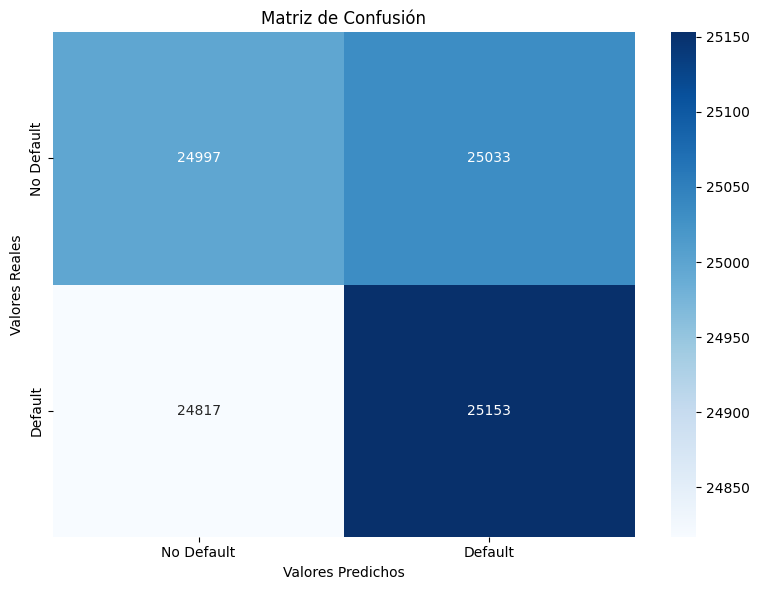


Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.50      0.50      0.50     50030
           1       0.50      0.50      0.50     49970

    accuracy                           0.50    100000
   macro avg       0.50      0.50      0.50    100000
weighted avg       0.50      0.50      0.50    100000

Fechas de nacimiento normalizadas. Fecha promedio calculada: 1980-06-16
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 7939
edades problemáticas: [200.0, 200.0, -5.0, -5.0, -5.0]
Edades corregidas desde fecha de nacimiento: 7938
Imputando fecha promedio para 1 casos sin fecha válida
Edad calculada desde fecha promedio: 45
Fechas de nacimiento nulas imputadas con moda: 1954-06-02 (casos: 11)
Valores nulos en Ingresos_Anuales imputados con moda: 35500.0 (casos: 1099)
Valores nulos en HistorialCredito imputados con moda: 25.0 (casos: 2467)
Valores nulos en Genero imputados con moda: F (casos

In [82]:
# Predicciones
y_pred = complete_pipeline.predict(X_test)
y_pred_proba = complete_pipeline.predict_proba(X_test)

# Métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

print(f"\n=== MÉTRICAS DE EVALUACIÓN ===")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Default', 'Default'],
            yticklabels=['No Default', 'Default'])
plt.title('Matriz de Confusión')
plt.ylabel('Valores Reales')
plt.xlabel('Valores Predichos')
plt.tight_layout()
plt.show()

# Reporte detallado
print(f"\nReporte de Clasificación:")
print(classification_report(y_test, y_pred))

# Validación cruzada
cv_scores = cross_val_score(complete_pipeline, X_train, y_train, cv=2, scoring='accuracy')
print(f"\nValidación Cruzada (5-fold):")
print(f"Accuracy promedio: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

## 7. Guardar pipeline.

In [83]:
joblib.dump(complete_pipeline, 'random_forest_pipeline.pkl')
print(f"\nPipeline guardado como 'random_forest_pipeline.pkl'")


Pipeline guardado como 'random_forest_pipeline.pkl'


## 8. Prueba de pipeline con archivo de prueba *test_inferencia.csv*

In [84]:
try:
    def get_cleaned_df_from_pipeline(pipeline, df_raw):
        """
        Devuelve el DataFrame limpiado usando el paso 'cleaning' del pipeline.
        """
        try:
            if hasattr(pipeline, "named_steps") and "cleaning" in pipeline.named_steps:
                cleaned = pipeline.named_steps["cleaning"].transform(df_raw)
                # Asegurar que sea DataFrame
                if not isinstance(cleaned, pd.DataFrame):
                    cleaned = pd.DataFrame(cleaned, index=df_raw.index)
                return cleaned
            else:
                return df_raw.copy()
        except Exception as e:
            print(f"No fue posible obtener el DataFrame limpio: {e}")
            return df_raw.copy()

    # Cargar archivo crudo
    test_data = pd.read_csv('test_inferencia.csv')
    print(f"\n=== INFERENCIA EN ARCHIVO DE PRUEBA ===")
    print(f"Forma del archivo de prueba (crudo): {test_data.shape}")

    # Obtener DF limpio (solo a efectos de salida/auditoría)
    cleaned_test_data = get_cleaned_df_from_pipeline(complete_pipeline, test_data)
    print(f"Forma del archivo de prueba (limpio): {cleaned_test_data.shape}")

    # Predicción usando TODO el pipeline (esto ya incluye limpieza/prepro)
    predictions  = complete_pipeline.predict(test_data)
    probabilities = complete_pipeline.predict_proba(test_data)

    # Crear DataFrame de resultados sobre el DF LIMPIO
    results = cleaned_test_data.copy()
    results['Prediccion'] = predictions
    results['Probabilidad_No_Default'] = probabilities[:, 0]
    results['Probabilidad_Default']    = probabilities[:, 1]

    if 'ID' in test_data.columns and 'ID' not in results.columns:
        results.insert(0, 'ID', test_data['ID'].values)

    # Guardar resultados
    results.to_csv('resultados_inferencia_limpio.csv', index=False)

    # Métricas rápidas
    try:
        binc = np.bincount(predictions.astype(int))
    except Exception:
        binc = pd.Series(predictions).value_counts().sort_index()
    print(f"Predicciones realizadas: {len(predictions)}")
    print(f"Distribución de predicciones: {binc}")
    print(f"Resultados (LIMPIO) guardados en 'resultados_inferencia_limpio.csv'")

    # Mostrar algunas predicciones
    print(f"\nPrimeras 10 predicciones:")
    cols_show = ['Prediccion', 'Probabilidad_Default']
    if 'ID' in results.columns:
        cols_show = ['ID'] + cols_show
    print(results[cols_show].head(10))
    display(results.head(20))

except FileNotFoundError:
    print(f"\nArchivo 'test_inferencia.csv' no encontrado.")
    print("Coloca el archivo en el directorio actual para realizar inferencias.")
except Exception as e:
    print(f"\nError al procesar archivo de inferencia: {str(e)}")



=== INFERENCIA EN ARCHIVO DE PRUEBA ===
Forma del archivo de prueba (crudo): (20, 10)
Fechas de nacimiento normalizadas. Fecha promedio calculada: 2000-08-15
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 11
edades problemáticas: [200.0, -5.0, 200.0, 200.0, -5.0]
Edades corregidas desde fecha de nacimiento: 7
Imputando fecha promedio para 4 casos sin fecha válida
Edad calculada desde fecha promedio: 25
Fechas de nacimiento nulas imputadas con moda: 2000-08-15 (casos: 3)
Valores nulos en Ingresos_Anuales imputados con moda: 48000.0 (casos: 1)
Valores nulos en HistorialCredito imputados con moda: 0.0 (casos: 2)
Valores nulos en Genero imputados con moda: F (casos: 3)
Valores nulos en Casado imputados con moda: No (casos: 4)
VERIFICACIÓN FINAL - Edades problemáticas restantes: 0
Outliers detectados en Ingresos_Anuales: 3
Forma del archivo de prueba (limpio): (20, 10)
Fechas de nacimiento normalizadas. Fecha promedio calculada: 2000-08-15

,ID,Edad,Genero,Ingresos_Anuales,HistorialCredito,Casado,FechaNacimiento,Telefono,Pais,CodigoPostal,Prediccion,Probabilidad_No_Default,Probabilidad_Default
0,1,25.0,F,48000.0,60.0,No,2000-08-15,3056385005,Argentina,B1600,1,0.497545,0.502455
1,2,25.0,F,72000.0,60.0,Si,2000-08-15,3126373965,Perú,17001,0,0.501967,0.498033
2,3,52.0,F,106875.0,85.0,No,2000-08-15,3715646984,Argentina,M5500,0,0.501554,0.498446
3,4,37.0,F,25000.0,0.0,No,1985-07-30,3223526094,México,44100,0,0.501896,0.498104
4,5,25.0,M,48000.0,0.0,No,2000-08-15,3454873478,Chile,8320000,1,0.494403,0.505597
5,6,25.0,F,106875.0,0.0,No,1985-07-30,3562189534,Argentina,M5500,0,0.521844,0.478156
6,7,25.0,M,72000.0,0.0,Si,2000-08-15,3578983110,Chile,7500000,1,0.496609,0.503391
7,8,52.0,M,48000.0,35.0,No,1978-11-09,3309154344,México,01000,0,0.501458,0.498542
8,9,25.0,F,48000.0,60.0,No,2000-08-15,3902967159,México,72000,1,0.497754,0.502246
9,10,25.0,F,0.0,0.0,No,2000-08-15,3693913546,Colombia,11001,0,0.522500,0.477500


## 9. Cargar y usar pipeline creado.

In [85]:
def load_and_predict(csv_file_path):
    """
    Función para cargar el pipeline guardado y hacer predicciones en nuevos datos
    """
    try:
        # Cargar pipeline
        loaded_pipeline = joblib.load('random_forest_pipeline.pkl')

        # Cargar datos
        new_data = pd.read_csv(csv_file_path)

        # Predicciones
        predictions = loaded_pipeline.predict(new_data)
        probabilities = loaded_pipeline.predict_proba(new_data)

        # Crear resultado
        results = new_data.copy()
        results['Prediccion'] = predictions
        results['Probabilidad_Default'] = probabilities[:, 1]

        return results

    except Exception as e:
        print(f"Error: {str(e)}")
        return None

In [86]:
print(load_and_predict('test_inferencia.csv'))

Fechas de nacimiento normalizadas. Fecha promedio calculada: 2000-08-15
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 11
edades problemáticas: [200.0, -5.0, 200.0, 200.0, -5.0]
Edades corregidas desde fecha de nacimiento: 7
Imputando fecha promedio para 4 casos sin fecha válida
Edad calculada desde fecha promedio: 25
Fechas de nacimiento nulas imputadas con moda: 2000-08-15 (casos: 3)
Valores nulos en Ingresos_Anuales imputados con moda: 48000.0 (casos: 1)
Valores nulos en HistorialCredito imputados con moda: 0.0 (casos: 2)
Valores nulos en Genero imputados con moda: F (casos: 3)
Valores nulos en Casado imputados con moda: No (casos: 4)
VERIFICACIÓN FINAL - Edades problemáticas restantes: 0
Outliers detectados en Ingresos_Anuales: 3
Fechas de nacimiento normalizadas. Fecha promedio calculada: 2000-08-15
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 11
edades problemáticas: [200.0, -5

## 10. Red Neuronal MLP (Arquitectura paso a paso).

### 10.1 Preparación y Arquitectura.

In [87]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier
import numpy as np

# Variables ya definidas previamente:
# numeric_features, categorical_features, X_train, X_test, y_train, y_test

# Preprocesador consistente con el usado en RF:
# - Numéricos: imputación simple + escalado
# - Categóricos: imputación simple + One-Hot

from sklearn.base import clone

mlp = MLPClassifier(
    hidden_layer_sizes=(32, 16),
    activation="relu",
    solver="adam",
    learning_rate_init=1e-3,
    early_stopping=True,
    n_iter_no_change=5,
    max_iter=200,
    random_state=42
)

# Clona la estructura (sin pesos entrenados) y reemplaza el último paso
mlp_pipeline = clone(complete_pipeline)
mlp_pipeline.set_params(classifier=mlp)

Pipeline(steps=[('cleaning',
                 Pipeline(steps=[('remove_duplicates',
                                  FunctionTransformer(func=<function remove_duplicates_func at 0x7c219be61e40>)),
                                 ('normalize_dates',
                                  FunctionTransformer(func=<function normalize_birth_date at 0x7c219be60360>)),
                                 ('clean_phones',
                                  FunctionTransformer(func=<function clean_phone at 0x7c219ea299e0>)),
                                 ('standardize_categorical',
                                  Function...
                                                   'HistorialCredito']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Genero', 'Casado', 'Pais',
                                                   'CodigoPostal',
                                                   'Telefono'])])),
                ('classifier',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(32, 16),
                               n_iter_no_change=5, random_state=42))])

### 10.2 Entrenamiento.

In [88]:
mlp_pipeline.fit(X_train, y_train)

Fechas de nacimiento normalizadas. Fecha promedio calculada: 1980-07-09
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 15986
edades problemáticas: [200.0, 200.0, -5.0, -5.0, 200.0]
Edades corregidas desde fecha de nacimiento: 15984
Imputando fecha promedio para 2 casos sin fecha válida
Edad calculada desde fecha promedio: 45
Fechas de nacimiento nulas imputadas con moda: 1980-12-25 (casos: 27)
Valores nulos en Ingresos_Anuales imputados con moda: 97000.0 (casos: 2189)
Valores nulos en HistorialCredito imputados con moda: 100.0 (casos: 4921)
Valores nulos en Genero imputados con moda: F (casos: 49837)
Valores nulos en Casado imputados con moda: No (casos: 57201)
Valores nulos en Telefono imputados con moda: 3112190805 (casos: 49854)
VERIFICACIÓN FINAL - Edades problemáticas restantes: 0
Outliers detectados en Ingresos_Anuales: 2222


Pipeline(steps=[('cleaning',
                 Pipeline(steps=[('remove_duplicates',
                                  FunctionTransformer(func=<function remove_duplicates_func at 0x7c219be61e40>)),
                                 ('normalize_dates',
                                  FunctionTransformer(func=<function normalize_birth_date at 0x7c219be60360>)),
                                 ('clean_phones',
                                  FunctionTransformer(func=<function clean_phone at 0x7c219ea299e0>)),
                                 ('standardize_categorical',
                                  Function...
                                                   'HistorialCredito']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['Genero', 'Casado', 'Pais',
                                                   'CodigoPostal',
                                                   'Telefono'])])),
                ('classifier',
                 MLPClassifier(early_stopping=True, hidden_layer_sizes=(32, 16),
                               n_iter_no_change=5, random_state=42))])

### 10.3 Evaluación en test.

In [89]:
y_pred = mlp_pipeline.predict(X_test)
# ... (mismas métricas que arriba)

mlp_metrics = {
    "accuracy": accuracy_score(y_test, y_pred),
    "precision": precision_score(y_test, y_pred, zero_division=0),
    "recall": recall_score(y_test, y_pred, zero_division=0),
    "f1": f1_score(y_test, y_pred, zero_division=0),
    "confusion_matrix": confusion_matrix(y_test, y_pred)
}

print("=== MLP - Métricas en Test ===")
for k, v in mlp_metrics.items():
    if k != "confusion_matrix":
        print(f"{k:>16}: {v:.4f}")
print("\nMatriz de confusión (MLP):")
print(mlp_metrics["confusion_matrix"])

# Reporte detallado opcional
print("\n=== Classification report (MLP) ===")
print(classification_report(y_test, y_pred, zero_division=0))

Fechas de nacimiento normalizadas. Fecha promedio calculada: 1980-07-09
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 4021
edades problemáticas: [200.0, 200.0, 200.0, 200.0, 200.0]
Edades corregidas desde fecha de nacimiento: 4021
Fechas de nacimiento nulas imputadas con moda: 1969-10-04 (casos: 15)
Valores nulos en Ingresos_Anuales imputados con moda: 28500.0 (casos: 583)
Valores nulos en HistorialCredito imputados con moda: 53.0 (casos: 1245)
Valores nulos en Genero imputados con moda: F (casos: 12471)
Valores nulos en Casado imputados con moda: No (casos: 14078)
Valores nulos en Telefono imputados con moda: 3930297402 (casos: 12544)
VERIFICACIÓN FINAL - Edades problemáticas restantes: 0
Outliers detectados en Ingresos_Anuales: 574
=== MLP - Métricas en Test ===
        accuracy: 0.5002
       precision: 0.4999
          recall: 0.5323
              f1: 0.5156

Matriz de confusión (MLP):
[[23421 26609]
 [23370 26600]]

=== Classific

### 11. Análisis y Conclusiones.

### 11.1 Comparación numérica RF vs. MLP.

In [90]:
try:
    import joblib
    rf_pipeline = joblib.load('random_forest_pipeline.pkl')
    y_pred_rf = rf_pipeline.predict(X_test)
    comp = {
        "Modelo": ["RandomForest", "MLP"],
        "Accuracy": [accuracy_score(y_test, y_pred_rf), mlp_metrics["accuracy"]],
        "Precision": [precision_score(y_test, y_pred_rf, zero_division=0), mlp_metrics["precision"]],
        "Recall": [recall_score(y_test, y_pred_rf, zero_division=0), mlp_metrics["recall"]],
        "F1": [f1_score(y_test, y_pred_rf, zero_division=0), mlp_metrics["f1"]],
    }
    import pandas as pd
    df_comp = pd.DataFrame(comp)
    print("\n=== Comparación RF vs. MLP (Test) ===")
    display(df_comp)
except Exception as e:
    print("\n[Aviso] No se pudo cargar 'rf_pipeline.joblib' para comparar RF vs. MLP.")
    print("Detalle:", e)

# Guardar la MLP para inferencia posterior como se hizo con RF
import joblib
joblib.dump(mlp_pipeline, "mlp_pipeline.joblib")
print("\nPipeline MLP guardado en 'mlp_pipeline.joblib'.")

Fechas de nacimiento normalizadas. Fecha promedio calculada: 1980-07-09
Columna de teléfono limpiada
Columnas categóricas estandarizadas
Edades problemáticas detectadas: 4021
edades problemáticas: [200.0, 200.0, 200.0, 200.0, 200.0]
Edades corregidas desde fecha de nacimiento: 4021
Fechas de nacimiento nulas imputadas con moda: 1969-10-04 (casos: 15)
Valores nulos en Ingresos_Anuales imputados con moda: 28500.0 (casos: 583)
Valores nulos en HistorialCredito imputados con moda: 53.0 (casos: 1245)
Valores nulos en Genero imputados con moda: F (casos: 12471)
Valores nulos en Casado imputados con moda: No (casos: 14078)
Valores nulos en Telefono imputados con moda: 3930297402 (casos: 12544)
VERIFICACIÓN FINAL - Edades problemáticas restantes: 0
Outliers detectados en Ingresos_Anuales: 574

=== Comparación RF vs. MLP (Test) ===


,Modelo,Accuracy,Precision,Recall,F1
0,RandomForest,0.50150,0.501196,0.503362,0.502276
1,MLP,0.50021,0.499915,0.532319,0.515609



Pipeline MLP guardado en 'mlp_pipeline.joblib'.


### 11.2 Interpretación de importancias en RF y posibles explicaciones.

In [91]:
import pandas as pd
import numpy as np

# 1) Extraer nombres de features transformadas y las importancias
rf_clf = complete_pipeline.named_steps["classifier"]
prep     = complete_pipeline.named_steps["preprocessing"]
feat_out = prep.get_feature_names_out()  # e.g., 'num__Edad', 'cat__Genero_M', etc.

rf_imp = pd.DataFrame({
    "feature": feat_out,
    "importance": rf_clf.feature_importances_
}).sort_values("importance", ascending=False)

print("=== Top 25 features transformadas (RF) ===")
display(rf_imp.head(25))

# 2) Agregar importancias por columna original (sumando dummies)
def original_col(name: str) -> str:
    # num__Edad -> Edad
    if name.startswith("num__"):
        return name.split("__", 1)[1]
    # cat__Genero_M -> Genero ; cat__EstadoCivil_Casado -> EstadoCivil
    if name.startswith("cat__"):
        rest = name.split("__", 1)[1]
        return rest.split("_", 1)[0]
    return name

rf_imp["orig_col"] = rf_imp["feature"].map(original_col)
rf_imp_agg = rf_imp.groupby("orig_col", as_index=False)["importance"].sum() \
                   .sort_values("importance", ascending=False)

print("=== Importancia agregada por columna original (RF) ===")
display(rf_imp_agg.head(15))

# (Opcional) Guardar a CSV
rf_imp.to_csv("rf_feature_importances_transformed.csv", index=False)
rf_imp_agg.to_csv("rf_feature_importances_by_column.csv", index=False)
print("Guardado: rf_feature_importances_transformed.csv y rf_feature_importances_by_column.csv")


=== Top 25 features transformadas (RF) ===


,feature,importance
1,num__Ingresos_Anuales,0.271093
0,num__Edad,0.245113
2,num__HistorialCredito,0.238772
3,cat__Genero_M,0.033400
4,cat__Casado_Si,0.032087
30,cat__Telefono_3112190805,0.007727
32,cat__Telefono_3310082776,0.007040
33,cat__Telefono_3329824500,0.007016
36,cat__Telefono_3718548711,0.006804
37,cat__Telefono_3831551336,0.006674


=== Importancia agregada por columna original (RF) ===


,orig_col,importance
5,Ingresos_Anuales,0.271093
2,Edad,0.245113
4,HistorialCredito,0.238772
7,Telefono,0.084834
1,CodigoPostal,0.077702
3,Genero,0.033400
0,Casado,0.032087
6,Pais,0.016998


Guardado: rf_feature_importances_transformed.csv y rf_feature_importances_by_column.csv


from matplotlib import pyplot as plt
_df_0['importance'].plot(kind='hist', bins=20, title='importance')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('orig_col').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['importance'].plot(kind='line', figsize=(8, 4), title='importance')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_3['orig_col'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_3, x='importance', y='orig_col', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

(MDI – mean decrease in impurity):

Las 3 numéricas dominantes son las esperables en un problema de default:

- Ingresos_Anuales (0.251)

- Edad (0.225)

- HistorialCredito (0.224)
Suman ~0.70 de la importancia total → son los drivers primarios.

Llama la atención la alta importancia agregada de:

- Telefono (0.103) y varias dummies con números exactos (p.ej., Telefono_3112190805, 9999999)

- CodigoPostal (0.094)

Posibles explicaciones:

- Sesgo por alta cardinalidad: La importancia MDI de los árboles tiende a favorecer variables con muchas categorías (como Telefono y CodigoPostal). Con OHE, esto introduce muchas dummies y el árbol puede “memorizar” patrones espurios → sube la “importancia” sin mejorar realmente la generalización.

- Fugas/ruido: Telefono luce como un ID/placeholder (ej. 9999999) o valores casi únicos por persona. Eso da cortes “fáciles” en árboles, pero no generaliza.

- CodigoPostal sí podría contener señal geográfica/socioeconómica real, pero en OHE de 5–6 dígitos terminas con cientos de dummies → propensión a sobreajuste. Mejor agrupar (prefijos o regiones).

Las variables numéricas (*Ingresos_Anuales, Edad, HistorialCredito*) son los explicadores confiables. La alta “importancia” de Telefono y la dispersión de Casado_* reflejan problemas de limpieza/representación y sesgo por cardinalidad más que información genuina.

### 11.3  Impacto de la limpieza.

- Normalización de fechas + cálculo de Edad: convierte cadenas heterogéneas en una variable numérica útil; añade señal para ambos modelos (MLP y RF).

- Estandarización de categóricas (uniformar etiquetas) + OHE: reduce cardinalidad errónea y evita valores “desconocidos” (gracias a handle_unknown="ignore"). Clave para MLP.

- Imputaciones por moda/mediana: evitan perder filas. Riesgo: si hay muchos nulos en una columna, puedes inducir sesgo; considera imputación más informada o un flag “faltante”.

- Outliers: reportaste muchos (Edad=1365, Ingresos=574).

- Para MLP, los outliers afectan más. Si no hiciste capping/winsorization, puede explicar parte del ruido.

- Para RF, suelen impactar menos, pero sí lo hacen si distorsionan particiones.

- Teléfono: típicamente no aporta poder predictivo (ID-like). Mejor quitarlo o transformarlo (longitud, prefijo).

### 11.4 Recomendación final.

Si el objetivo es capturar la mayor cantidad de defaults (minimizar falsos negativos):
- Es mejor la MLP tal como está, y ajusta el umbral de decisión (por defecto 0.5) para subir recall manteniendo F1 aceptable. Añade calibración (Platt/Isotónica) y compara curvas PR.

Si priorizamos menor tasa de falsos positivos (operación costosa por “marcar de más”):

- Ajustar umbral con RF y/o MLP y elegir el que logre mayor precision a la recall mínima aceptable.